# Quality Assurance Validation Plots
---

Date taken: June 9, 2021<br/>
Events: ~3000<br/>
Bias: 0 V<br/>

FEB ID: XXX<br/>
Half-modules: XXX<br/>

Data is being used to test QA code.

In [1]:
# Enable the widget backend. This requires installing ipympl. 
#%matplotlib widget

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

import matplotlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv('feb_data.csv')
df

,RCE,FEB,Hybrid,APV,channel,pchannel,sample0,sample1,sample2,sample3,sample4,sample5,error,head,tail,filter
0,0,0,1,0,0,512,101,621,1135,1643,2153,2681,0,1,0,0
1,0,0,1,0,0,512,3396,3960,4068,4004,4116,4028,0,0,0,0
2,0,0,1,0,32,544,2396,3232,3472,3540,3660,3452,0,0,0,0
3,0,0,1,0,64,576,2668,3432,3688,3684,3744,3744,0,0,0,0
4,0,0,1,0,96,608,3428,4148,4156,4280,4076,4100,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3515503,0,0,1,0,119,631,4996,5068,4980,4908,4784,4744,0,0,0,0
3515504,0,0,1,0,31,543,3720,3852,3700,3544,3640,3616,0,0,0,0
3515505,0,0,1,0,63,575,4020,4016,3960,3992,4016,3892,0,0,0,0
3515506,0,0,1,0,95,607,4420,4448,4424,4392,4452,4432,0,0,0,0


In [4]:
color_dict = [ "#E69F00", "#56B4E9", "#009E73", 
          "#F0E442", "#0072B2", "#D55E00", "#CC79A7" ]

# Utiliy function to create dictionary
def multi_dict(k, type):
    if k == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(k-1, type))

def draw_baseline2d(df, hybrid, channels, samples, cut):
    
    matplotlib.rcParams.update({'font.size': 22})
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), 
                         facecolor='white')

    # Define the number of bins to use in x and y
    bins_x = np.linspace(0, 639, 640)
    bins_y = 1000
    
    # Create the 2d histogram
    histo, x_edges, y_edges = np.histogram2d(channels, 
                                             samples, 
                                             bins=[bins_x, bins_y])
    
    # The histogram needs to be rotated
    histo = np.rot90(histo)
    histo = np.flipud(histo)
    
    # Mask out all bins that have a value of 0
    histo_mask = np.ma.masked_where(histo==0, histo)
    
    # Plot the data and add the heatmap
    plt.pcolormesh(x_edges - 0.5, y_edges, histo_mask, cmap='jet', 
                   norm=colors.LogNorm())
    cbar = plt.colorbar()
    
    ax.set_xlim([-2, 641])
    
    ax.set_xlabel('Physical Channel', fontsize=30)
    ax.set_ylabel('Sample %s Baseline (ADC Counts)' % sample, fontsize=30)
    ax.set_title('Hybrid %s' % hybrid, x=.5, fontweight='bold')
    
def draw_mean_baseline(ax, hybrid, sample, samples, channels):
    label = 'Sample %s' % sample
    ax.plot(channels, samples, 'o', color=color_dict[sample], alpha=0.5,
            label=label)
    ax.set_xlabel('Physical Channel', fontsize=30)
    ax.set_ylabel('Mean Baseline (ADC Counts)', fontsize=30)
    ax.set_title('Hybrid %s' % hybrid, x=.5, fontweight='bold')
    ax.legend()

def draw_noise(ax, hybrid, sample, noise, channels):
    label = 'Sample %s' % sample
    ax.plot(channels, noise, 'o', color=color_dict[sample], alpha=0.5,
            label=label)
    ax.set_xlabel('Physical Channel', fontsize=30)
    ax.set_ylabel('Noise (ADC Counts)', fontsize=30)
    ax.set_title('Hybrid %s' % hybrid, x=.5, fontweight='bold')
    ax.legend()
    

In [5]:
# Get a list of hybrids to process
hybrids = df['Hybrid'].unique()

# Define the total number of samples per sample block
sample_count = 6

# Define cuts and generate commonly used datasets. This is done
# here to save time on processing. 
# Note, requiring "head" to be zero removes header events
hybrid_cuts = {}
hybrid_channels = {}
hybrid_unique_channels = {}
hybrid_samples = multi_dict(2, int)
hybrid_channel_samples = multi_dict(3, int)
for hybrid in hybrids: 
    hybrid_cuts[hybrid] = (df['Hybrid'] == hybrid) & (df['head'] == 0)
    hybrid_channels[hybrid] = df['pchannel'][hybrid_cuts[hybrid]]
    hybrid_unique_channels[hybrid] = hybrid_channels[hybrid].unique()
    for sample in range(0, sample_count):
        hybrid_samples[hybrid][sample] = df['sample%s' % sample][hybrid_cuts[hybrid]]

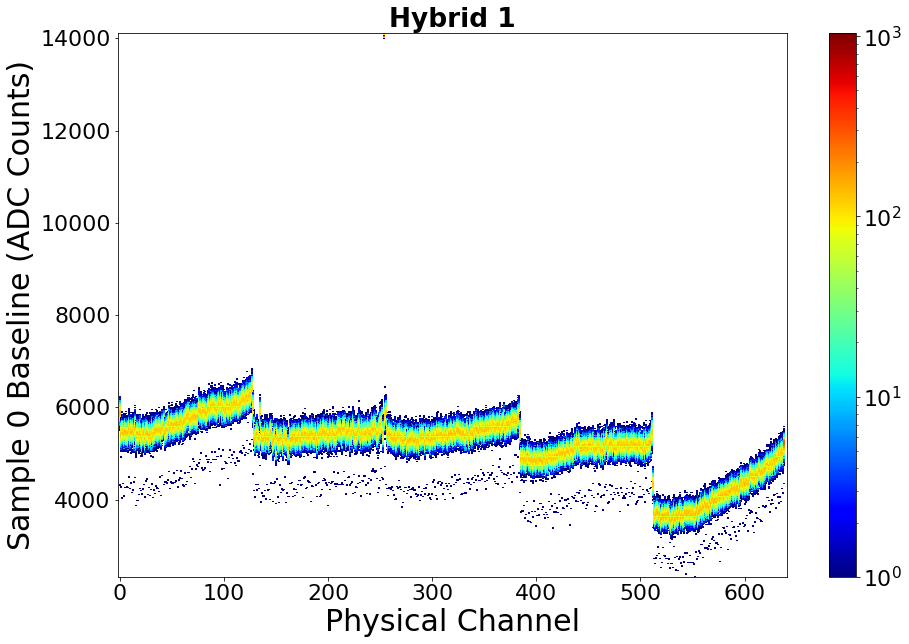

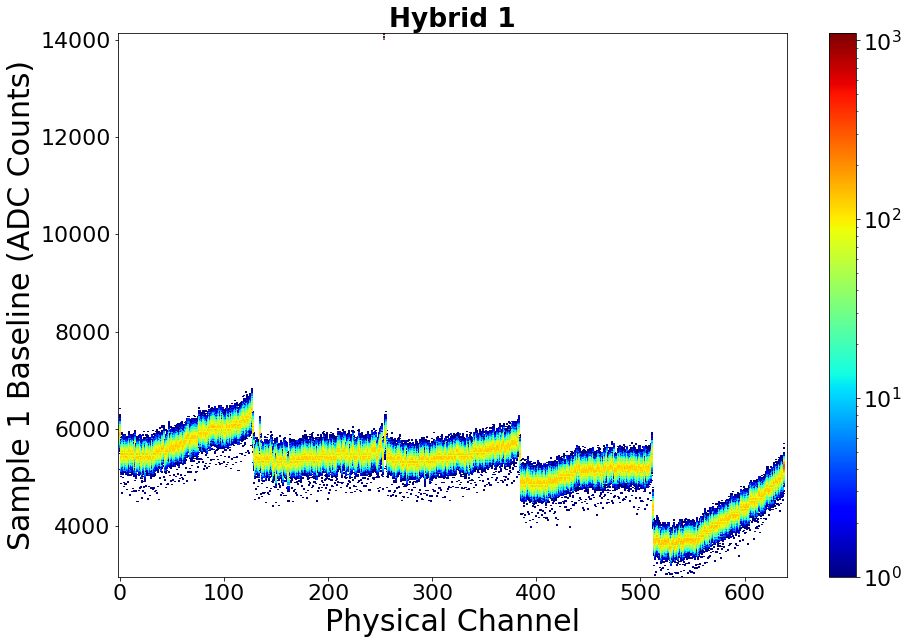

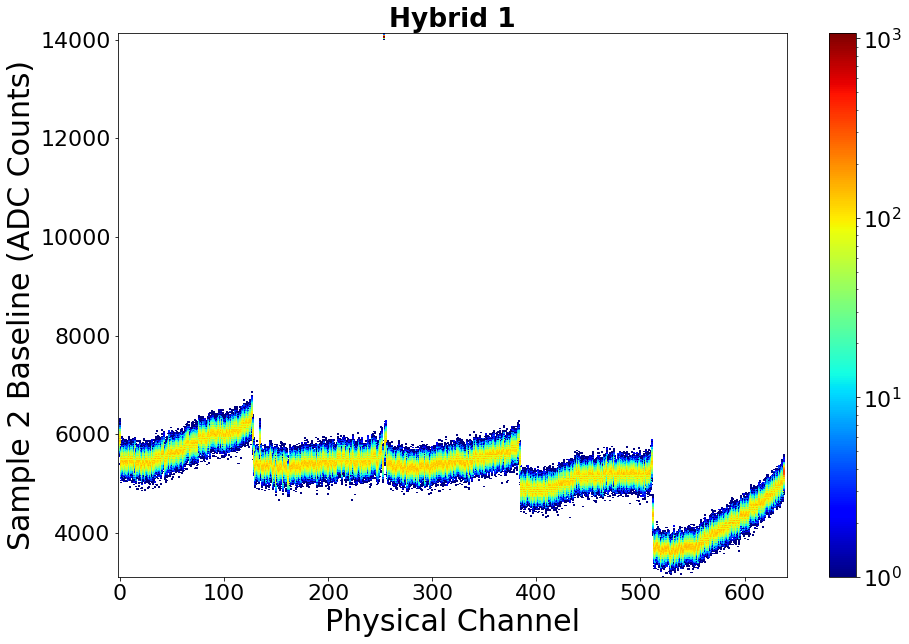

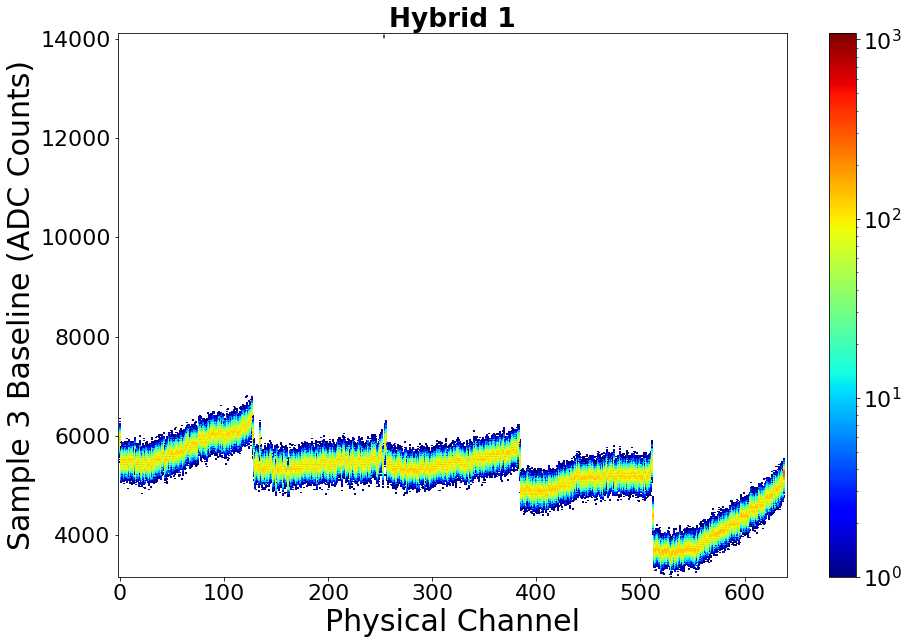

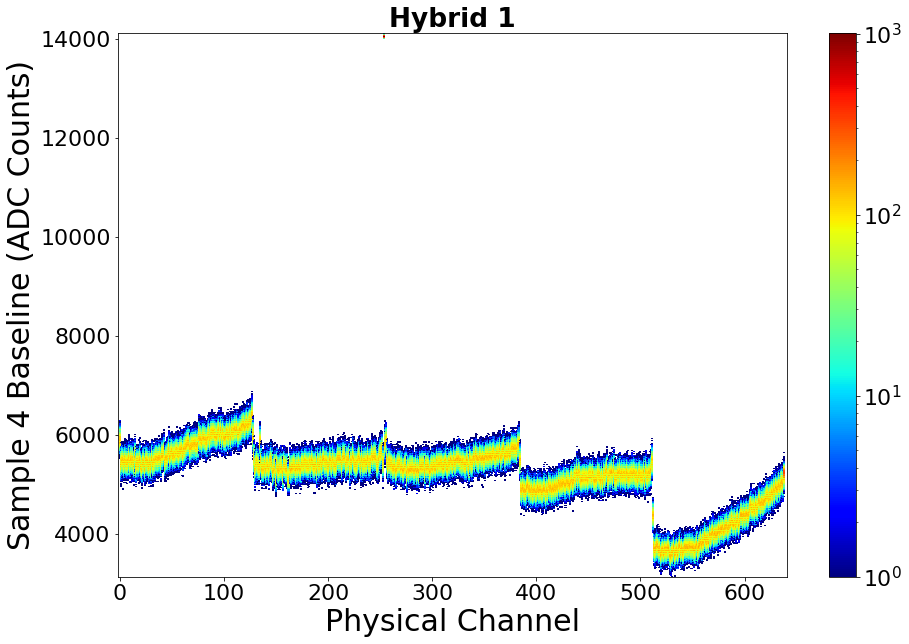

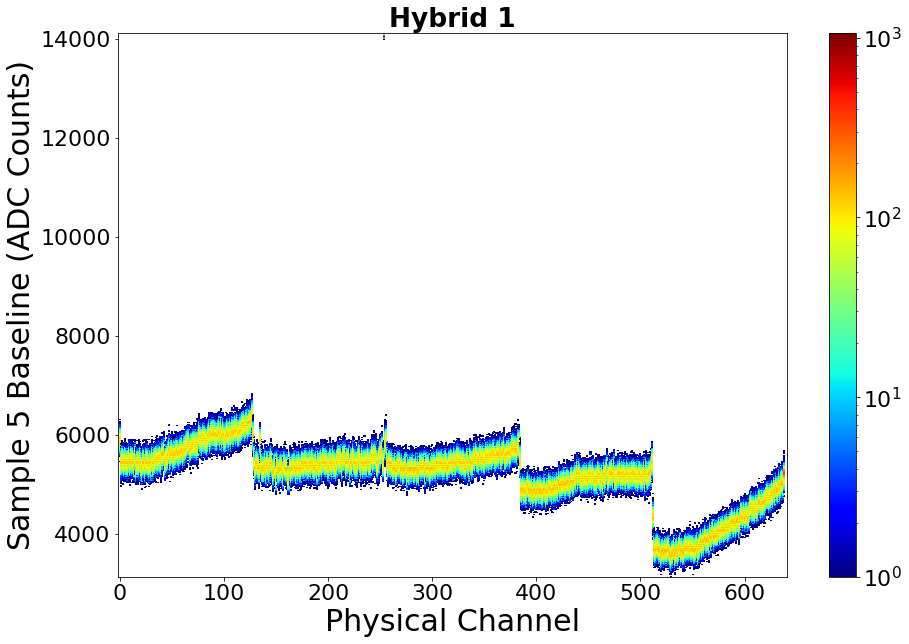

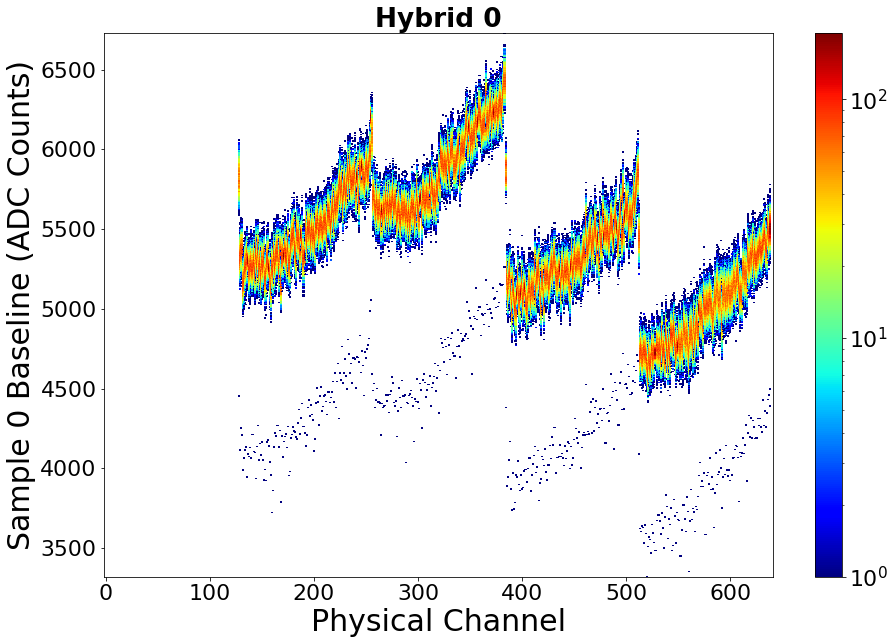

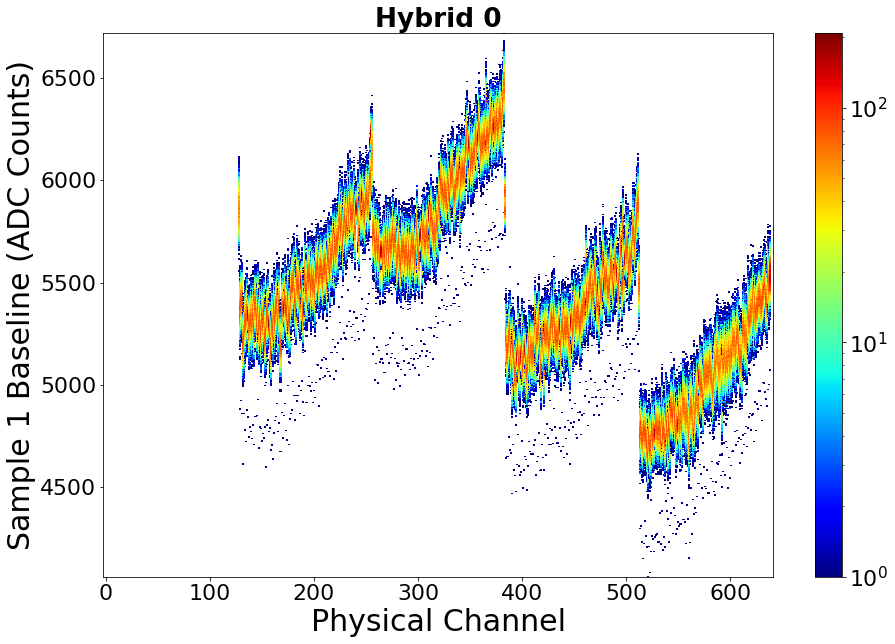

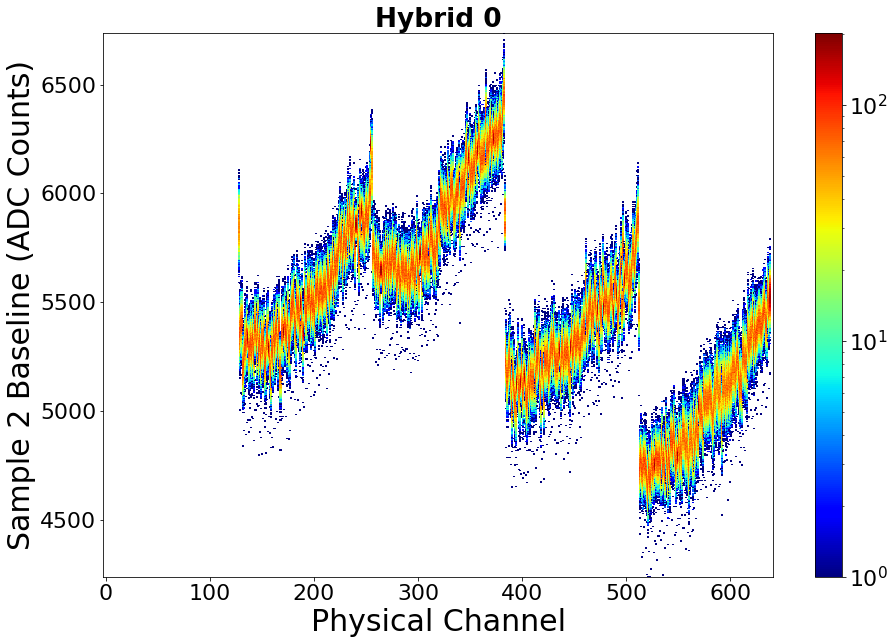

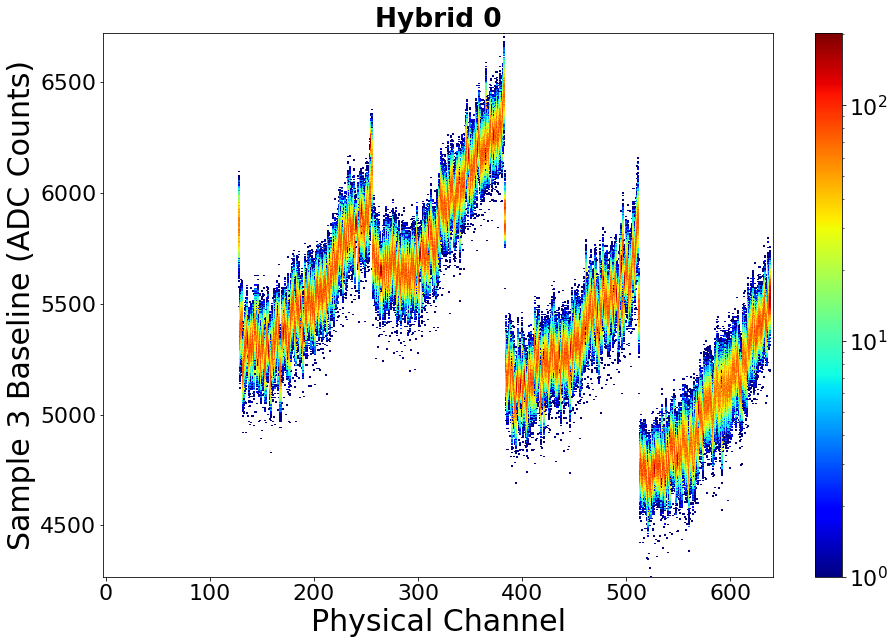

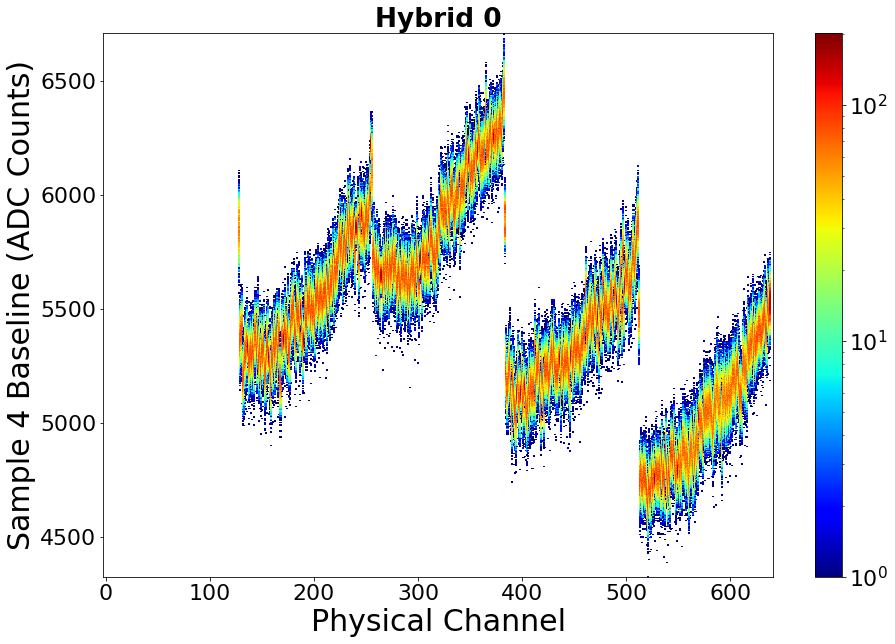

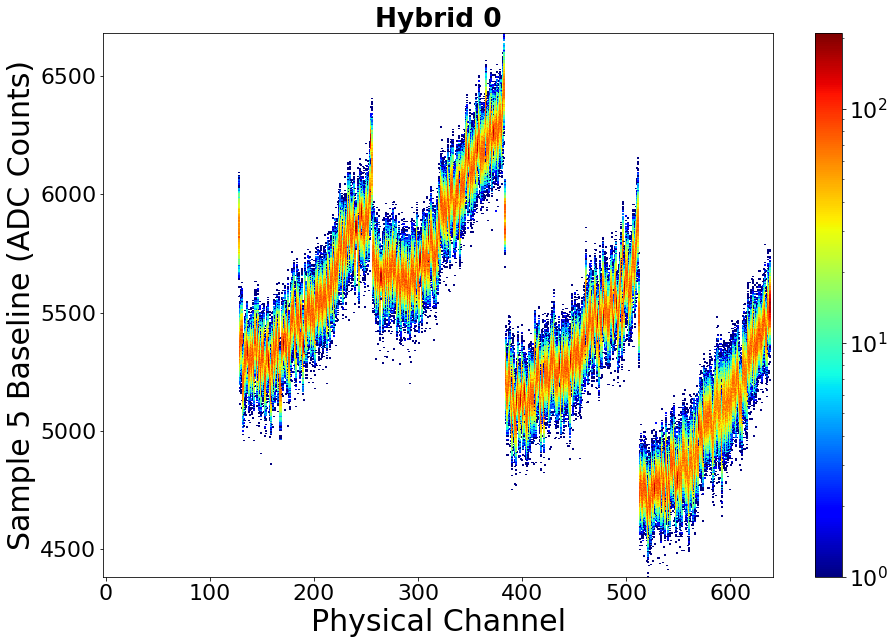

In [6]:
for hybrid in hybrids: 
    for sample in range(0, sample_count):
        draw_baseline2d(df, hybrid, hybrid_channels[hybrid], hybrid_samples[hybrid][sample], hybrid_cuts[hybrid])

In [7]:
%%time
mean = multi_dict(3, float)
noise = multi_dict(3, float)
channels = {}

for hybrid in hybrids: 
    for channel in hybrid_unique_channels[hybrid]:
        cut = hybrid_cuts[hybrid] & (df['pchannel'] == channel)
        channels[hybrid] = channel
        for sample in range(0, sample_count): 
            samples = df['sample%s' % sample][cut]
            mean[hybrid][sample][channel] = samples.mean()
            noise[hybrid][sample][channel] = samples.std()

CPU times: user 2min 22s, sys: 72.7 ms, total: 2min 22s
Wall time: 2min 23s


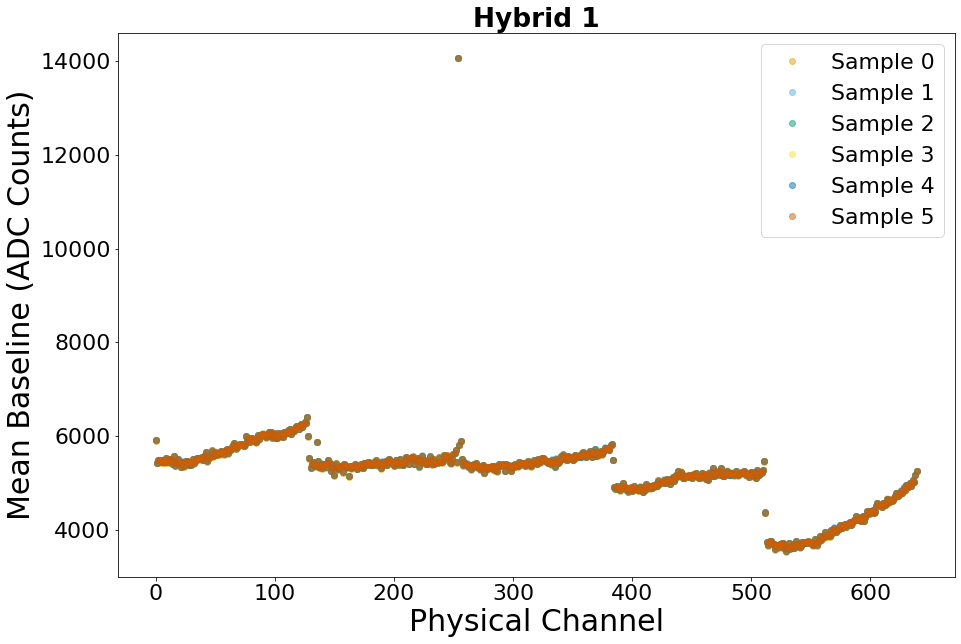

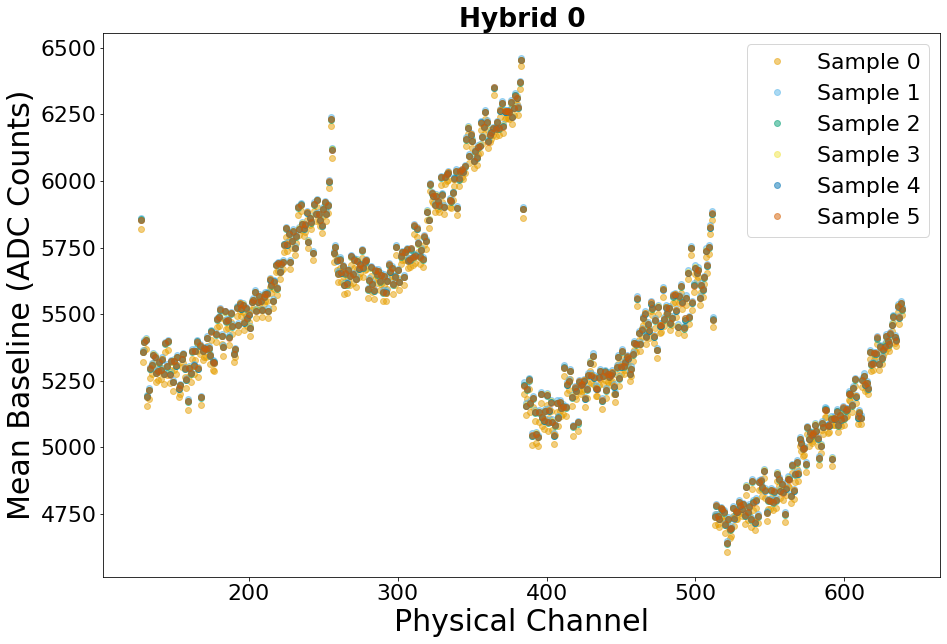

In [8]:
for hybrid in hybrids:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), 
                           facecolor='white')
    for sample in range(0, sample_count):
        draw_mean_baseline(ax, hybrid, sample, 
                           mean[hybrid][sample].values(), 
                           mean[hybrid][sample].keys())

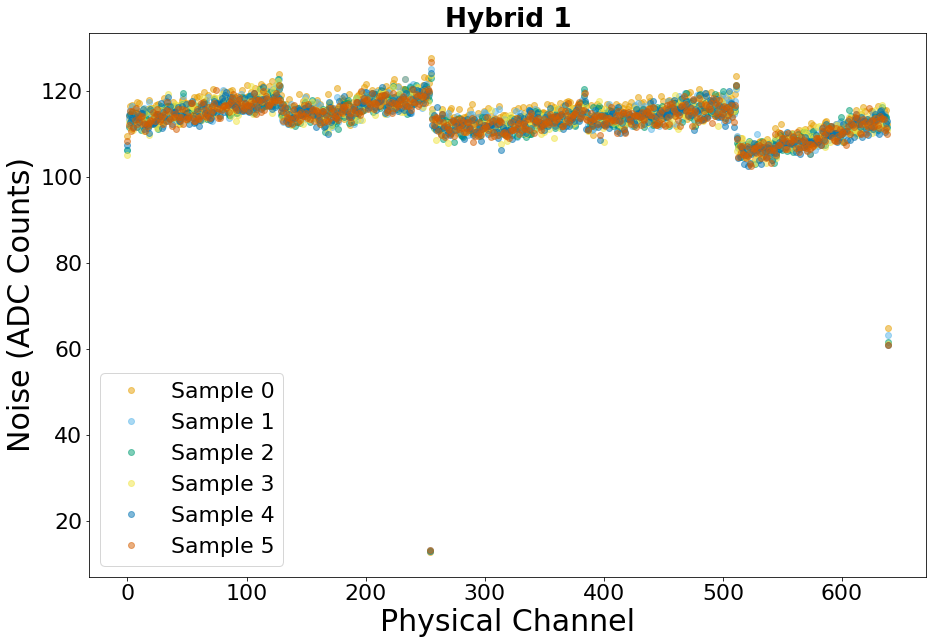

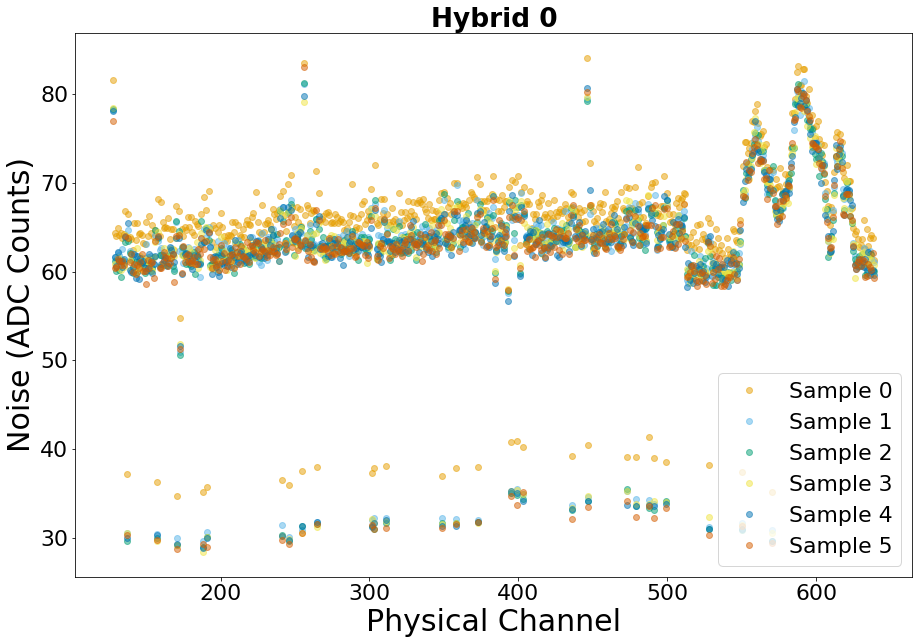

In [9]:
for hybrid in hybrids:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), 
                           facecolor='white')
    for sample in range(0, sample_count):
        draw_noise(ax, hybrid, sample, 
                        noise[hybrid][sample].values(), 
                        noise[hybrid][sample].keys())